In [509]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib as mpl
import seaborn as sns
# from sklearn import preprocessing
from tqdm import trange, tqdm
from math import floor
from copy import copy

# from src import data_handling
mpl.rcParams['figure.facecolor'] = 'white'
# mpl.rcParams['figure.dpi'] = 175

d:\OneDrive - UNSW\RedbackNMP\redback_ds_nmp


In [508]:
%cd ..

d:\OneDrive - UNSW\RedbackNMP


In [540]:
# Constants
RAW_DATA_DIR = 'data\\raw\\'
INPUTS_FILE = 'input_params.csv'
OUTPUTS_FILE = 'output.csv'
TOTAL_SETUPS = 51

X_COL = 'WorldPosition_X'
Z_COL = 'WorldPosition_Z'
LAP_COL = 'acsys.CS.LapCount'
TIME_COL = 'acsys.CS.LapTime'
THROTTLE_COL = 'acsys.CS.Gas'
SPEED_COL = 'acsys.CS.SpeedKMH'
BRAKE_COL = 'acsys.CS.Brake'
GEAR_COL = 'acsys.CS.Gear'
STEERING_COL = 'acsys.CS.Steer'
ENERGY_COL = 'ERSCurrentKJRunningTotaledKMH'
ENERGY_DELTA_COL = 'energy_delta'
TIME_DELTA_COL = 'time_delta'
POSITION_COL = 'acsys.CS.NormalizedSplinePosition'

SETUP_N_COL = 'setup_n'
VARIANCE_COL = 'variance'

PARAM_COL = 'parameter'
VALUE_COL = 'value'
FASTEST_TIME_COL = 'fastest_time'
AVERAGE_TIME_COL = 'average_time'

DEFAULT_COLS_TO_DISPLAY = [SPEED_COL, THROTTLE_COL, BRAKE_COL, STEERING_COL]

SEC_1 = (-45.487949, 59.597862)
SEC_2 = (-11.066800, -12.740685)
SEC_3 = (35.477341, 65.179382)
T_OF_INTEREST = [[2, 3.5], [5.5, 9], [14.8, 18.1], [19, 22], [26, 27.4], [28.8, 30.2], [31.7, 34.2], [34.9, 37.5]]

FAST_LAP_THRESHOLD_MAX = 50_000
FAST_LAP_THRESHOLD_MIN = 36_000

FIG_SIZE = (12,8)
SMALL_SCALE = 5


0: Let's make some functions to help us with importing data and visualising the track

In [551]:
### TOOLS FOR LOADING AND DISPLAYING DATA

def load_setup(n: int = 0, cols: list = None, out: bool = True) -> list[pd.DataFrame]:
    # Load inputs and outputs
    # NOTE: outputs is indexed from 1 onwards as index 0 seems to be at origin
    inputs = pd.read_csv(f'{RAW_DATA_DIR}data0_{n:02}\\{INPUTS_FILE}')
    if out:
        outputs = pd.read_csv(f'{RAW_DATA_DIR}data0_{n:02}\\{OUTPUTS_FILE}').iloc[1:]

        if cols is not None:
            outputs = outputs[cols]
    
        return inputs, outputs

    else:
        return inputs


def display_map(df: pd.DataFrame, index_range: list = None, 
                hue: str = "acsys.CS.LapTime", plot_size: float = 10,
                tick_multiple: int = 10, highlight_indexes : list = []) -> None:

    # NOTE: hue not implemented
    # NOTE: CURRENTLY IMPLEMENTED USING TIME VALUES, SPLINE POSITION WOULD BE BETTER
    #       HOWEVER, TIME CONSTRAINTS
    # Check Params
    if index_range == None: index_range = [0, df.index[-1] - 1]

    # Adj. Vars
    df = df.iloc[index_range[0]:index_range[1]]
    
    # Set up axes
    fig, ax = plt.subplots(figsize=(plot_size, plot_size))
    ax.set_aspect('equal')
    ax.grid(color='grey', linestyle=':')

    # Add ticks
    x_ticks = list(np.arange(0, min(df[X_COL]), -tick_multiple)) + list(np.arange(0, max(df[X_COL]), tick_multiple))
    ax.xaxis.set_ticks(x_ticks)
    y_ticks = list(np.arange(0, min(df[Z_COL]), -tick_multiple)) + list(np.arange(0, max(df[Z_COL]), tick_multiple))
    ax.yaxis.set_ticks(y_ticks)

    # Plot
    ax.scatter(x=df[X_COL], y=df[Z_COL], marker='.', linewidths=1)

    if len(highlight_indexes) != 0:
        ax.scatter(x=df[X_COL].iloc[highlight_indexes], y=df[Z_COL].iloc[highlight_indexes], marker='o', linewidths=10)


def display_lap(df, lap, **kwargs):
    df = get_lap(df, lap)
    display_map(df, **kwargs)


def get_n_of_laps(df):
    return df[LAP_COL].nunique()


def get_lap(df: pd.DataFrame, lap: int):
    return df[df[LAP_COL] == lap]


def get_laps(df: pd.DataFrame, lap_range: list = None):
    if lap_range != None:
        return df[df[LAP_COL] >= lap_range[0]][df[LAP_COL] <= lap_range[1]]


def clean_data(df: pd.DataFrame, additional: list = [],
               keep: list = [TIME_COL, LAP_COL, X_COL, Z_COL, THROTTLE_COL, SPEED_COL, BRAKE_COL, STEERING_COL, ENERGY_COL, POSITION_COL]):
    # # Plotting laps, we see normal laps are less than 60 000
    # # And disregard 0th and last lap cus funky stuff
    # # 
    # fig, ax = plt.subplots()
    # ax.xaxis.set_ticks(np.arange(0, 20, 1))
    # for i in range(10):
    #     df_in, df = load_setup(i)
    #     ax.plot(df[[LAP_COL, TIME_COL]][df[LAP_COL].diff().shift(-1).fillna(1) == 1].set_index(LAP_COL))

    # add additional and keep
    # keep is the "core" attributes, "additional is any extra"
    # they're seprate so you can easily add more cols without having to rewrite the og "keep" ones
    keep += additional

    # Get the cols we're interested in
    df = df[keep]

    # Remove first and last lap
    df = df.iloc[1:-1]

    # Make sure all laps are under 60 000 ms
    lap_times = get_lap_times(df)
    for lap_n in lap_times.index:
        lap_time = lap_times.iloc[lap_n][TIME_COL]
        if not (FAST_LAP_THRESHOLD_MIN < lap_time < FAST_LAP_THRESHOLD_MAX):
            df.drop(df[df[LAP_COL] == lap_n].index , inplace=True)
    
    # Fix lap count
    df[LAP_COL] -= 1

    for i, lap_n in enumerate(get_lap_times(df).index):
        if i != lap_n:
            df.loc[df[LAP_COL] == lap_n, LAP_COL] = i
    
    df.reset_index(inplace=True, drop=True)
    
    # Now fix n_lap to match spline pos
    # print(df[df[POSITION_COL].diff() < 0].index)
    # print(f"{df.tail()=}")
    # get_lap_times(df).plot()
    for i in df[df[POSITION_COL].diff() < 0].index:
        # print(i)
        new_lap_n = df.loc[i-1][LAP_COL] + 1
        
        index_to_fix_to = get_lap(df, new_lap_n).index.tolist()

        if len(index_to_fix_to) > 0:
            df.loc[i:index_to_fix_to[0], LAP_COL] = new_lap_n
        
        else:
            df.drop(index=df.loc[i:,].index, inplace=True, )
            break
            # print(f'{i} dropped')
        
        # print(f'max index is {df.index.tolist()[-1]}')

    return df


def get_lap_times(df: pd.DataFrame) -> pd.DataFrame:
    return df[[LAP_COL, TIME_COL]][df[LAP_COL].diff().shift(-1).fillna(1) != 0].set_index(LAP_COL)


def get_speed_lap(df: pd.DataFrame, fastest: bool = True, return_time: bool = False):
    times = get_lap_times(df)

    if fastest:
        time = min(times[TIME_COL])
    else:
        time = max(times[TIME_COL])
    
    if return_time:
        return time
    
    else:
        return times.index[times[TIME_COL] == time].tolist()[0]


def get_t_range(df, t_range, s: bool = False): 
    t_range = copy(t_range)
    if s:
        t_range[0] *= 1000
        t_range[1] *= 1000
    return df[ df[TIME_COL] >= t_range[0] ][ df[TIME_COL] <= t_range[1] ]


def get_p_range(df, p_range): 
    p_range = copy(p_range)
    return df[ df[POSITION_COL] >= p_range[0] ][ df[POSITION_COL] <= p_range[1] ]


def display_lap_data(df: pd.DataFrame, this_lap_ns = [], benchmark_lap_ns = [], t_step: float = 2.5, t_range: list = [], add_map: bool = False, with_respect_to: str = TIME_COL,
                     analyse: list = [SPEED_COL, THROTTLE_COL, BRAKE_COL, STEERING_COL], small: bool = False):

    # Setup figure
    fig_size = list(FIG_SIZE)
    if small: 
        fig_size[0] /= SMALL_SCALE
        fig_size[1] /= SMALL_SCALE
    fig = plt.figure(figsize=fig_size)
    # gs = fig.add_gridspec(len(analyse)+1, hspace=0)

    gs = fig.add_gridspec(len(analyse), hspace=0)
    axs = gs.subplots(sharex=True)

    # Get dfs
    if df.index.name != None:
        df = df.reset_index(drop=False)
    # print(f'{df.head()=}')

    if type(this_lap_ns) == int:
        this_lap_ns = [this_lap_ns]
    if type(benchmark_lap_ns) == int:
        benchmark_lap_ns = [benchmark_lap_ns]
    
    if this_lap_ns == []:
        this_lap_ns = [df[LAP_COL].min()]
        benchmark_lap_ns = [df[LAP_COL].min()]

    benchmark_dfs = [get_lap(df, i) for _, i in enumerate(benchmark_lap_ns)]
    dfs = [get_lap(df, i) for _, i  in enumerate(this_lap_ns)]

    # print(f'{dfs[0].head()=}')

    # NOTE: lots of opperations can defs be optimised, rn just getting something that works

    # Axis and t_range stuff, idk its messy, dw abt it, 
    if t_range != []:
        _t_range = [t_range[0] * 1000, t_range[1] * 1000]
        dfs = [get_t_range(_df, _t_range) for _, _df in enumerate(dfs)]
        benchmark_dfs = [get_t_range(_df, _t_range) for _, _df in enumerate(benchmark_dfs)]
    else:
        t_range = [0, dfs[0][TIME_COL].max() / 1000]
        # print(f'{t_range=}')
    if with_respect_to == TIME_COL:
        axs[-1].set_xlabel('time (s)')
        axs[-1].xaxis.set_ticks(np.arange(t_range[0], (t_range[1] // t_step) * t_step, t_step).tolist())

    else:
        axs[-1].set_xlabel(with_respect_to)
        axs[-1].xaxis.set_ticks(np.arange(dfs[0].loc[:, with_respect_to].min().round(3), (dfs[0].loc[:, with_respect_to].max().round(3) // t_step) * t_step, t_step).tolist())
    # print(f'{np.arange(0, (df[TIME_COL].iloc[-1] // t_interval) * t_interval / 1000, t_interval / 1000).tolist()=}')
    # df, benchmark_df = add_time_deltas(df, benchmark_df)
    # ADD TIME DELTA LATER

    # ax.yaxis.set_tick_params(labelsize='large') OR small

    # some info abt it
    print(f'RED LAP ({benchmark_lap_ns}) TIME[0]: {benchmark_dfs[0][TIME_COL].iloc[-1]/1000:.2f}s')
    print(f'BLUE LAP ({this_lap_ns}) TIME[0]: {dfs[0][TIME_COL].iloc[-1]/1000:.2f}s')

    for i in range(len(analyse)):
        axs[i].grid(color='grey', linestyle=':')
        axs[i].set_title(analyse[i], loc='left', pad=-15)

        for _, _df in enumerate(benchmark_dfs):
            # i know this implementation is super botched, but im running outa time rn so this'll have to do for the moment, sorry for your eyes
            if with_respect_to == TIME_COL:
                axs[i].plot(_df[TIME_COL]/1000, _df[analyse[i]], c='r')
            else:
                axs[i].plot(_df[with_respect_to], _df[analyse[i]], c='r')

        for _, _df in enumerate(dfs):
            if with_respect_to == TIME_COL:
                axs[i].plot(_df[TIME_COL]/1000, _df[analyse[i]], c='b')
            else:
                axs[i].plot(_df[with_respect_to], _df[analyse[i]], c='b')
    
    if add_map:
        _t_range = [t_range[0] * 1000, t_range[1] * 1000]

        _df = get_lap(df, this_lap_ns[0])
        _df.reset_index(inplace=True, drop=True)
        # print(_df.head())
        # print(_df.tail())
        # print(f'{get_t_range(_df, _t_range).iloc[0, TIME_COL]=}')
        index = get_t_range(_df, _t_range).index
        print(f'{get_t_range(_df, _t_range).index[0]=}')

        display_map(_df, highlight_indexes=index)
        # display_map(df)


def fastest_laps(df, n: int):
    _df = get_lap_times(df).sort_values(by=[TIME_COL])
    fastest_ns = _df.index.tolist()[:n]

    return fastest_ns, _df.loc[fastest_ns, TIME_COL].tolist()


In [284]:
### DERIVE DATA


def add_energy_delta(df: pd.DataFrame):
    # Due to the removal of laps, can have energy delta spikes so we na those
    # Easier to do it to first dp of all laps
    df[ENERGY_DELTA_COL] = df[ENERGY_COL].diff()
    
    # df[df[LAP_COL].diff().fillna(1) != 0, ENERGY_DELTA_COL] = np.nan
    df.loc[df[LAP_COL].diff().fillna(1) != 0, ENERGY_DELTA_COL] = np.nan

    return df


def get_df_delta(df1: pd.DataFrame, df2: pd.DataFrame, cols = []):
    # This is a poor implementation but I don't know how you would otherwise compare the data given their
    # indexes are slightly different

    # assume df1 is the smaller of the two
    if len(df1.index) > len(df2.index):
        tmp = df2
        df1 = df2
        df2 = tmp

    min = df1.index.min()
    max = df1.index.max()
    n = len(df1.index)
    df2.drop(df2.iloc[n:].index, inplace=True)

    index_name = df1.index.name
    df1.reset_index(inplace=True)
    df2.reset_index(inplace=True)

    # print(f'{n=}\n{len(df1.index)=}\n{len(df2.index)=}')
    # print(f'{df1.columns=}\n{df2.columns=}')
    # print(f'{df1.head()=}\n\n{df2.head()=}\n\n')

    # for i in range(n):
    #     # index not mutable so we change to col and then put back
    #     df1.loc[i, index_name] = min + i * (max - min) / n 
    #     df2.loc[i, index_name] = min + i * (max - min) / n 

    # print(f'{len([min + i * (max - min) / n for i in range(n)])=}')
    df1[index_name] = [min + i * (max - min) / n for i in range(n)]
    df2[index_name] = [min + i * (max - min) / n for i in range(n)]
    # df1[index_name] = min
    # df2[index_name] = min
    
    df1.set_index(index_name, drop=True, inplace=True)
    df2.set_index(index_name, drop=True, inplace=True)

    # df_diff = df1[cols]
    df_diff = df1[cols] - df2[cols]
    df_diff[[TIME_COL, LAP_COL]] = df1[[TIME_COL, LAP_COL]]

    return df_diff


# # HARD TO IMPLEMENT AS TIMESERIES DATA NOT AT SAME INTERVALS, CANT DIRECTLY COMPARE TO SUBTRACT
# def add_time_deltas(df_delta, df_base):
#     df_base[TIME_DELTA_COL] = 0
#     df_delta[TIME_DELTA_COL] = df_delta[TIME_COL] - df_base[TIME_COL]
#     return df_delta, df_base


In [340]:
### "NUMERICAL" FUNCTIONS


def lap_correlation(fast_lap: pd.DataFrame, compare_lap: pd.DataFrame, 
                         data_inputs: list = [THROTTLE_COL, BRAKE_COL, STEERING_COL]):

    # Yes reseting indexes has lots of problems but I don't know how you would properly
    # "align" the datasets for such a comparison

    fast_lap.reset_index(inplace=True, drop=True)
    compare_lap.reset_index(inplace=True, drop=True)
    
    corr = compare_lap[data_inputs].corrwith(fast_lap[data_inputs])
    return corr.sort_values()


def get_variances(df, cols: list = DEFAULT_COLS_TO_DISPLAY, norm: dict = {}):
    df = copy(df)

    for col in norm.keys():
        print(col)
        df[col] = df[col] / norm[col]

    vars = df[cols].var()
    return vars


# (1) OF A GIVEN SETUP:
## (1.1) Displays and examines data of a given car setup

In [174]:
df_in, df_out = load_setup(42)
df = clean_data(df_out)
# df = add_energy_delta(df)

# fig, ax = plt.subplots()
# ax.xaxis.set_ticks(np.arange(0, 20, 1))
# for i in range(10):
#     df_in, df = load_setup(i)
#     #ax.plot(df[[LAP_COL, TIME_COL]][df[LAP_COL].diff().shift(-1).fillna(1) == 1].set_index(LAP_COL))
#     print(df[[LAP_COL, TIME_COL]][df[LAP_COL].diff().shift(-1).fillna(1) == 1].set_index(LAP_COL).iloc[-1])



RED LAP ([2]) TIME[0]: 42.32s
BLUE LAP ([8]) TIME[0]: 41.95s
RED LAP ([2]) TIME[0]: 18.50s
BLUE LAP ([8]) TIME[0]: 18.50s
RED LAP ([2]) TIME[0]: 18.50s
BLUE LAP ([8]) TIME[0]: 18.50s


C:\Users\nicis\AppData\Local\Temp/ipykernel_304/455527308.py:145: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return df[ df[TIME_COL] >= t_range[0] ][ df[TIME_COL] <= t_range[1] ]
C:\Users\nicis\AppData\Local\Temp/ipykernel_304/455527308.py:145: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return df[ df[TIME_COL] >= t_range[0] ][ df[TIME_COL] <= t_range[1] ]
C:\Users\nicis\AppData\Local\Temp/ipykernel_304/455527308.py:145: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return df[ df[TIME_COL] >= t_range[0] ][ df[TIME_COL] <= t_range[1] ]


get_t_range(_df, _t_range).index[0]=682


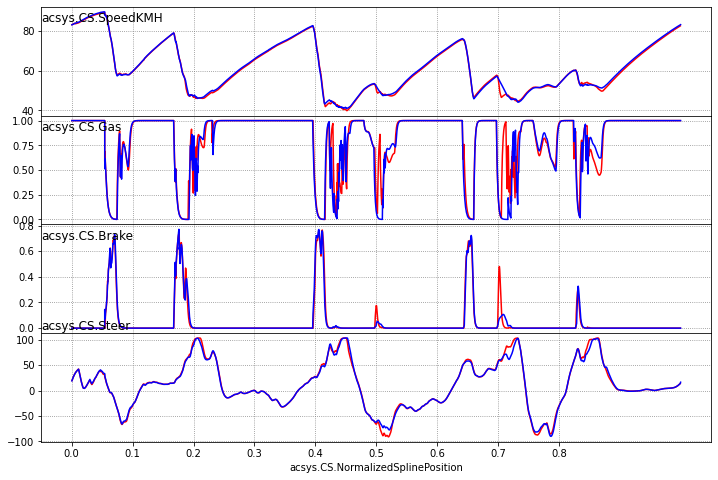

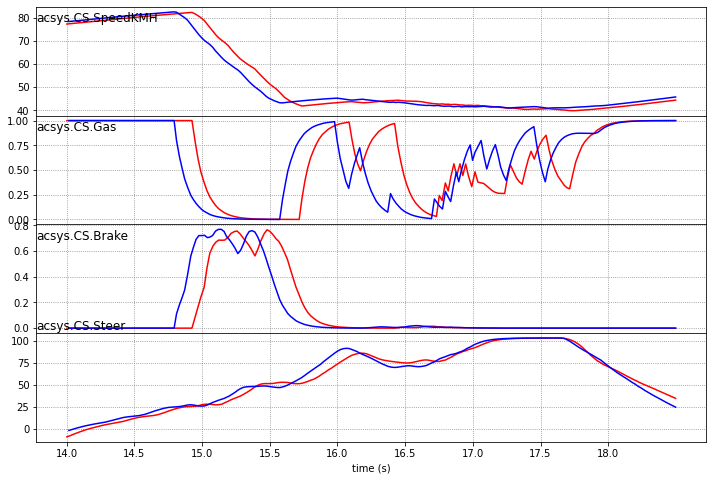

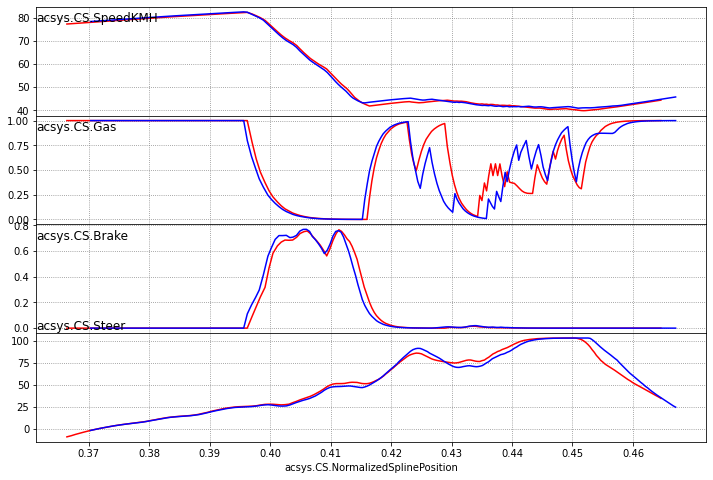

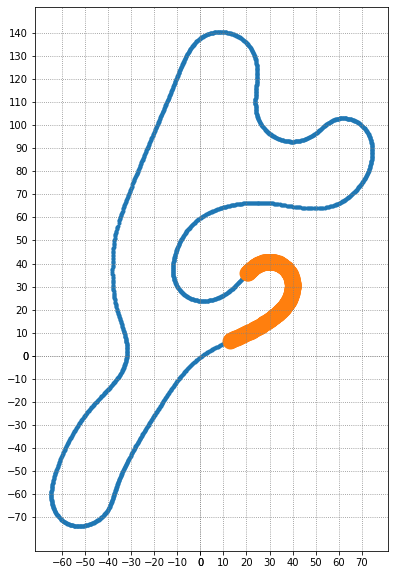

In [320]:
# Analyse Fastest n_1 vs Slowest n_2
times = get_lap_times(df)
# times.set_index(TIME_COL, drop=False, inplace=True)
times.reset_index(drop=False, inplace=True)
times.set_index(TIME_COL, inplace=True)
times.sort_index(inplace=True)
lap_ns = times[LAP_COL].tolist()

n_of_laps = 1

# fastest_laps = lap_ns[-n_of_laps:]
# slowest_laps = lap_ns[:n_of_laps]

df_fastest = get_lap(df, fastest_laps[0])
df_slowest = get_lap(df, slowest_laps[0])

# print(f'{times=}')
 
display_lap_data(df, slowest_laps, fastest_laps, with_respect_to=POSITION_COL, t_step=0.1)
display_lap_data(df, slowest_laps, fastest_laps, t_range=[14, 18.5], t_step=0.5)
display_lap_data(df, slowest_laps, fastest_laps, t_range=[14, 18.5], t_step=0.01, with_respect_to=POSITION_COL, add_map=True)  # note still indexed by time interval, pos needs to be implemented

#TODO: add colour bar for map corresponding to time so can easily look between sets of data

RED LAP ([2]) TIME[0]: 42.32s
BLUE LAP ([8]) TIME[0]: 41.95s
RED LAP ([2]) TIME[0]: 42.32s
BLUE LAP ([2]) TIME[0]: 42.32s
acsys.CS.Steer
acsys.CS.Gas      0.088001
acsys.CS.Brake    0.020816
acsys.CS.Steer    0.250933
dtype: float64


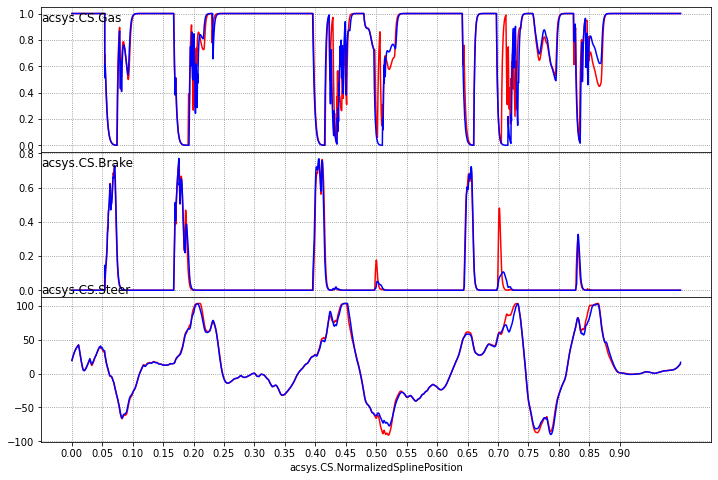

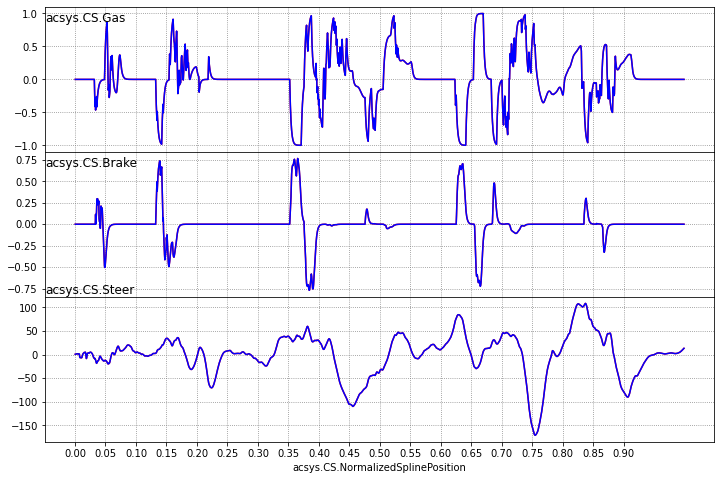

In [342]:
p_range = [0, 1]
cols = [THROTTLE_COL, BRAKE_COL, STEERING_COL]

dff = get_p_range(df_fastest, p_range).set_index(POSITION_COL)
dfs = get_p_range(df_slowest, p_range).set_index(POSITION_COL)

df_diff = get_df_delta(dff, dfs, cols=cols)

display_lap_data(df, slowest_laps, fastest_laps, with_respect_to=POSITION_COL, analyse=cols, t_step=0.05)
display_lap_data(df_diff, with_respect_to=POSITION_COL, analyse=cols, t_step=0.05)

print(get_variances(df, cols=cols, norm = {STEERING_COL: 100}))

# (2) Comparing Setups
## (2.1) Consistency -> Minimal Variance in Lap Times

In [586]:
lap_time_variances = pd.Series(np.zeros(TOTAL_SETUPS, dtype=float))
lap_time_averages = pd.Series(np.zeros(TOTAL_SETUPS, dtype=float))
fastest_lap_times = pd.Series(np.zeros(TOTAL_SETUPS, dtype=float))

for i in range(TOTAL_SETUPS):
    if i != 47:
        print(f'{i}--', end='')
        df_in, df = load_setup(i)
        df = clean_data(df)
        lap_time_variances[i] = np.array(get_lap_times(df)).var()
        lap_time_averages[i] = np.array(get_lap_times(df)).mean()
        fastest_lap_times[i] = np.array(fastest_laps(df, 1)[1][0])

# TODO: look at 47

0--1--2--3--4--5--6--7--8--9--10--11--12--13--14--15--16--17--18--19--20--21--22--23--24--25--26--27--28--29--30--31--32--33--34--35--36--37--38--39--40--41--42--43--44--45--46--48--49--50--

In [591]:
# weird stuff happening with 47, need to investigate further

lap_time_variances.drop(47, inplace=True)
lap_time_averages.drop(47, inplace=True)
fastest_lap_times.drop(47, inplace=True)

Smallest Var: [12, 30, 5, 26]	Largest Var: [6, 16, 46, 4]
Smallest Avg: [16, 10, 20, 35]	Largest Avg: [14, 39, 22, 41]
Fastest Lap: [16, 6, 46, 20]	Slowest Lap: [39, 14, 22, 41]


[[<matplotlib.lines.Line2D at 0x2092acf91f0>],

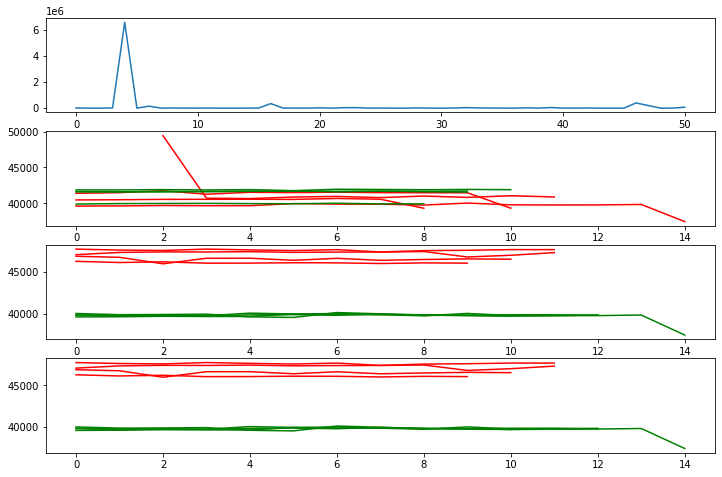

In [592]:
fig, axs = plt.subplots(nrows=4, figsize=FIG_SIZE)
n = 4

axs[0].plot(lap_time_variances)

vars = lap_time_variances.sort_values().index.tolist()
avgs = lap_time_averages.sort_values().index.tolist()
fast_laps = fastest_lap_times.sort_values().index.tolist()

print(f'Smallest Var: {vars[:n]}\tLargest Var: {vars[-n:]}')
print(f'Smallest Avg: {avgs[:n]}\tLargest Avg: {avgs[-n:]}')
print(f'Fastest Lap: {fast_laps[:n]}\tSlowest Lap: {fast_laps[-n:]}')


# [get_lap_times(clean_data(load_setup(lap)[1])) for lap in vars.nsmallest(2)]


[axs[1].plot(get_lap_times(clean_data(load_setup(lap)[1])), c='r') for lap in vars[-n:]]
[axs[1].plot(get_lap_times(clean_data(load_setup(lap)[1])), c='g') for lap in vars[:n]]

[axs[2].plot(get_lap_times(clean_data(load_setup(lap)[1])), c='r') for lap in avgs[-n:]]
[axs[2].plot(get_lap_times(clean_data(load_setup(lap)[1])), c='g') for lap in avgs[:n]]

[axs[3].plot(get_lap_times(clean_data(load_setup(lap)[1])), c='r') for lap in avgs[-n:]]
[axs[3].plot(get_lap_times(clean_data(load_setup(lap)[1])), c='g') for lap in avgs[:n]]

# VARIANCE SEEMS TO FAVOUR SHORTER LAPS, NOT ACCURATE OR NEED TO CLIP LAP COUNT OF ALL TO THE SMALLEST (IN THIS CASE 8)
#[axs[3].plot(get_lap_times(clean_data(load_setup(lap)[1])), c='g') for lap in vars[:n]]


pearson
parameter
suspensions_FRONT_TOE_OUT    0.665598
average_time                 1.000000
Name: average_time, dtype: float64
kendall
parameter
suspensions_FRONT_TOE_OUT    0.485891
average_time                 1.000000
Name: average_time, dtype: float64
spearman
parameter
suspensions_FRONT_TOE_OUT    0.635178
average_time                 1.000000
Name: average_time, dtype: float64


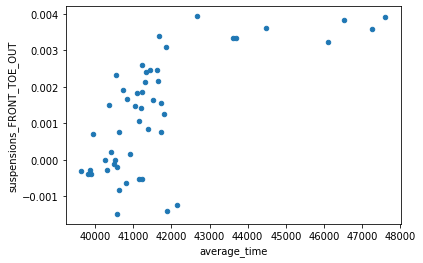

In [607]:
dfs = []

for i in avgs:
    df_in = load_setup(i, out=False)

    df_in = df_in.set_index(PARAM_COL).transpose()
    df_in[AVERAGE_TIME_COL] = lap_time_averages.loc[i]
    # df_in.set_index(AVERAGE_TIME_COL, drop=True, inplace=True)

    dfs.append(df_in)

df_setups = pd.concat(dfs)

df_setups.plot.scatter(x=AVERAGE_TIME_COL, y='suspensions_FRONT_TOE_OUT')

for m in ['pearson', 'kendall', 'spearman']:
    print(m)
    corr = df_setups.corr(method=m)[AVERAGE_TIME_COL]
    print(corr[corr > 0.3])

pearson
parameter
suspensions_FRONT_TOE_OUT    0.661976
fastest_time                 1.000000
Name: fastest_time, dtype: float64
kendall
parameter
suspensions_FRONT_TOE_OUT    0.480361
fastest_time                 1.000000
Name: fastest_time, dtype: float64
spearman
parameter
suspensions_FRONT_TOE_OUT    0.633705
suspensions_REAR_TOE_OUT     0.232334
fastest_time                 1.000000
Name: fastest_time, dtype: float64


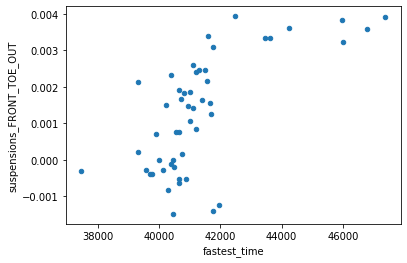

In [603]:
dfs = []

for i in avgs:
    df_in = load_setup(i, out=False)

    df_in = df_in.set_index(PARAM_COL).transpose()
    df_in[FASTEST_TIME_COL] = fastest_lap_times.loc[i]
    # df_in.set_index(AVERAGE_TIME_COL, drop=True, inplace=True)

    dfs.append(df_in)

df_setups = pd.concat(dfs)

df_setups.plot.scatter(x=FASTEST_TIME_COL, y='suspensions_FRONT_TOE_OUT')

for m in ['pearson', 'kendall', 'spearman']:
    print(m)
    corr = df_setups.corr(method=m)[FASTEST_TIME_COL]
    print(corr[corr > 0.2])

<AxesSubplot:xlabel='average_time', ylabel='tyres_REAR_PRESSURE_STATIC'>

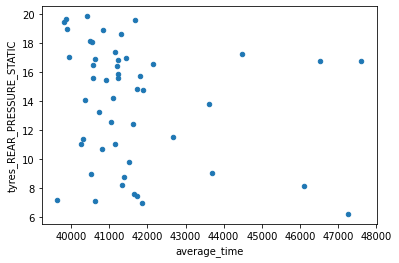

In [608]:
df_setups.plot.scatter(x=AVERAGE_TIME_COL, y='tyres_REAR_PRESSURE_STATIC')
# df_setups.columns

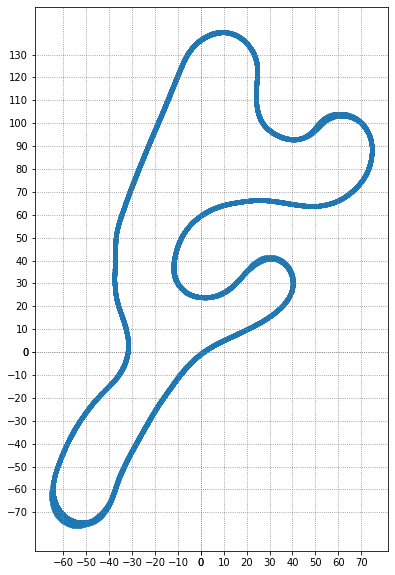

In [609]:
display_map(df)